In [1]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [10]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [16]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [40]:
cap = cv2.VideoCapture('/content/drive/My Drive/Colab Notebooks/old-man.mp4')

aboutU = input("당신은 어떤 특징을 가졌습니까?")
address = input("당신의 주소를 입력해주세요 : ")

state = False
while(True) :
  stateInput = input("isFire ? [y / n]")
  answer = ['y', 'n']
  if not (stateInput in answer) :
    print("y 와 n 중에 입력해주세요 !")
    continue
  else :
    if stateInput == "y" :
      state = True
    elif stateInput == "n" :
      state = False
    break
if state == True :
  print("현재 상태 : 화재 발생")
  ret, frame = cap.read()
  img = frame
  print("현재 현장 이미지 정보를 가져오는 데 성공했습니다.")
else :
  print("현재 상태 : 안전")

당신은 어떤 특징을 가졌습니까?y
당신의 주소를 입력해주세요 : y
isFire ? [y / n]y
현재 상태 : 화재 발생
현재 현장 이미지 정보를 가져오는 데 성공했습니다.


In [41]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

In [42]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
print(outputs)

tensor([ 0, 62], device='cuda:0')
Boxes(tensor([[ 577.6927,  322.3363,  655.2392,  397.2774],
        [1043.5188,  530.1786, 1280.0000,  717.7277]], device='cuda:0'))
{'instances': Instances(num_instances=2, image_height=720, image_width=1280, fields=[pred_boxes: Boxes(tensor([[ 577.6927,  322.3363,  655.2392,  397.2774],
        [1043.5188,  530.1786, 1280.0000,  717.7277]], device='cuda:0')), scores: tensor([0.9962, 0.6325], device='cuda:0'), pred_classes: tensor([ 0, 62], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
  

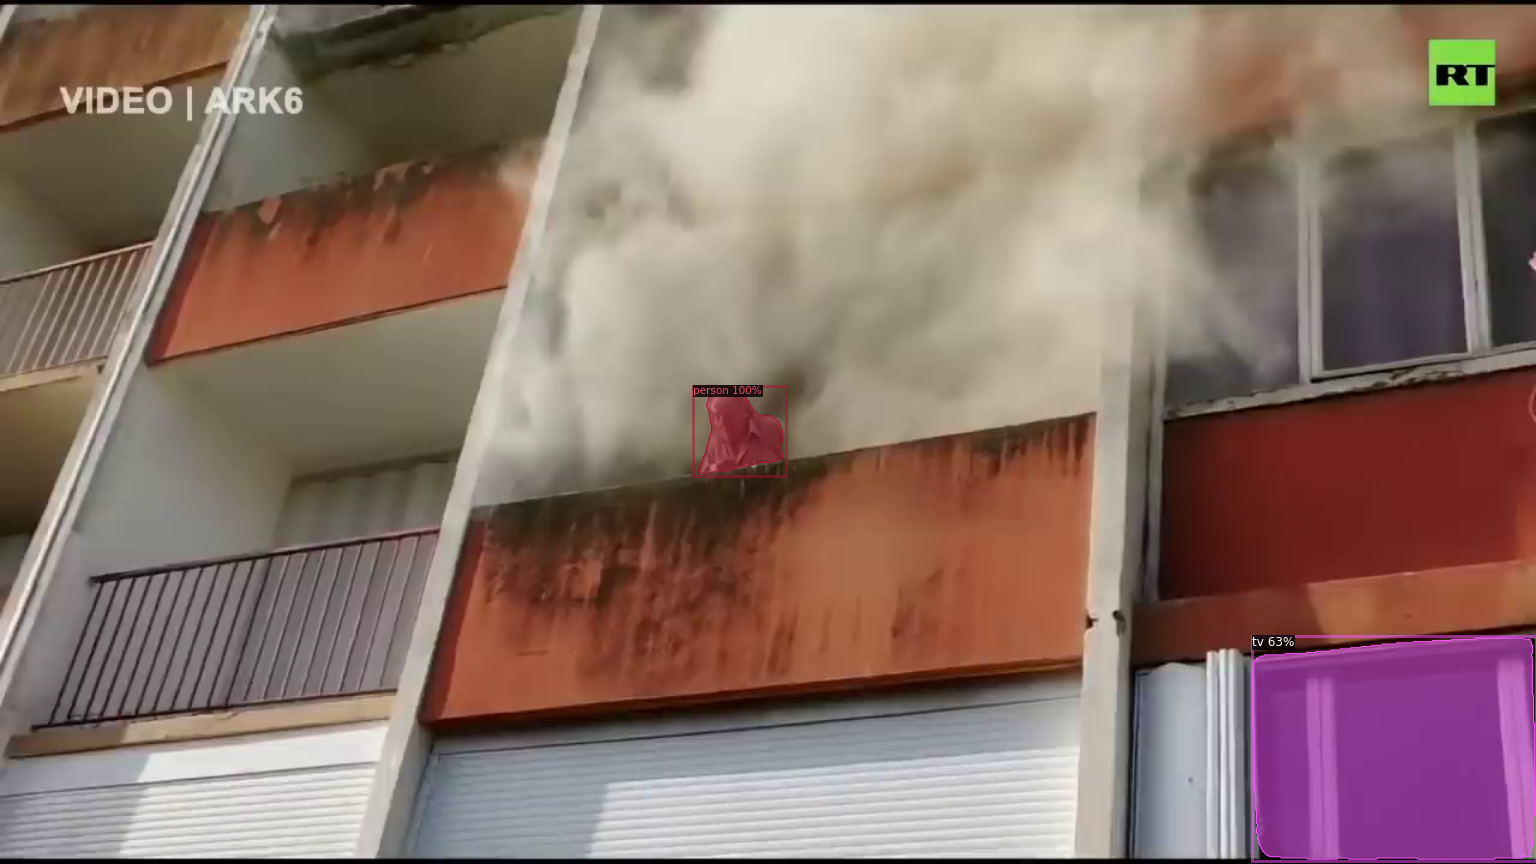

In [43]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])